# 🧱 Tiny CNN 训练 Notebook

面向 TinyML SoC 的玻璃破碎 baseline：Notebook 仅负责 orchestrator，具体逻辑封装在 `src/` helper 中。

## ✅ 执行步骤
1. Inspect：加载 balanced index，确认分布。
2. K-Fold：针对全部 fold 运行训练，保存各折 checkpoint。
3. Analyze：可视化各折指标，挑选最佳 fold。
4. Drill-down：查看最佳 fold 的训练曲线、混淆矩阵。
5. Export：保存最佳权重 & 历史，并导出 ONNX 供后续 INT8 流水线使用。

In [1]:
# Cell: Environment & Imports
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from src.config import SEED, LABEL_TO_ID, BACKGROUND_LABEL, NUM_CLASSES
from src.datasets import load_index_df, build_dataloaders
from src.models import TinyGlassNet, count_parameters
from src.training import run_kfold_training
from src.metrics import confusion_matrix, plot_confusion_matrix
from src.export import export_to_onnx

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
sns.set_theme(style="whitegrid")


## ⚙️ 配置与超参
集中管理数据路径、折划分、训练/导出参数以及更精细的超参（class weight、grad clip）。

In [2]:
# Cell: Experiment Configuration
INDEX_CANDIDATES = [
    Path('cache/window_index.parquet'),
    Path('cache/window_index.csv'),
]
INDEX_PATH = next((p for p in INDEX_CANDIDATES if p.exists()), INDEX_CANDIDATES[-1])

K_FOLD_LIST = (1, 2, 3, 4, 5)
BEST_METRIC = 'f1'  # 可切换为 'recall' 等

BATCH_SIZE = 64
NUM_WORKERS = 0
EPOCHS = 60
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
EARLY_STOPPING = 8
LR_PATIENCE = 4
LR_FACTOR = 0.5
CLASS_WEIGHTS = (1.0, 1.0)  # weights aligned to TARGET_LABELS order (glass=0, gunshot=1)
GRAD_CLIP_NORM = 1.0
SMOKE_TEST = False
SMOKE_LIMIT = 128 if SMOKE_TEST else None
COLLATE_MAX_FRAMES = None

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_DIR = Path('cache/experiments')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
KFOLD_DIR = OUTPUT_DIR / 'kfold'
ONNX_PATH = OUTPUT_DIR / 'tinyglassnet_best.onnx'


## 🛠️ Helper Builders
定义模型、损失、优化器、调度器构造方法，以及 DataLoader 的公共配置。

In [3]:
# Cell: Builder Functions

loader_kwargs = dict(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    smoke_limit=SMOKE_LIMIT,
    collate_max_frames=COLLATE_MAX_FRAMES,
)

def build_model():
    return TinyGlassNet()

def build_criterion():
    pos_w = torch.tensor(CLASS_WEIGHTS, device=DEVICE, dtype=torch.float32)
    return nn.BCEWithLogitsLoss(pos_weight=pos_w)

def build_optimizer(params):
    return torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

def build_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=LR_PATIENCE, factor=LR_FACTOR)

print(f"Model params: {count_parameters(build_model()):,}")


Model params: 23,314


## 📁 加载索引并检查分布

In [4]:
# Cell: Load Balanced Index

import ast

index_df = load_index_df(INDEX_PATH)
print(f'Loaded index: {INDEX_PATH} | samples={len(index_df)}')

# Ensure path column exists (compat with older indices)
if 'path' not in index_df.columns:
    alt_cols = [c for c in ['filepath','mel_path'] if c in index_df.columns]
    if alt_cols:
        index_df['path'] = index_df[alt_cols[0]]
        print(f"path missing; using {alt_cols[0]} instead")
    else:
        raise KeyError("Index is missing 'path' column; regenerate cache/index_balanced.csv from prepare_new.ipynb")

# 兼容旧索引：补 label / labels
if 'label' not in index_df.columns:
    index_df['label'] = index_df.get('target_label', index_df.get('orig_label', BACKGROUND_LABEL))
if 'labels' not in index_df.columns:
    index_df['labels'] = index_df['label'].apply(lambda x: [x] if pd.notna(x) else [])

def _to_list(val):
    if val is None:
        return []
    if isinstance(val, str):
        try:
            val = ast.literal_eval(val)
        except Exception:
            val = [val]
    if not isinstance(val, (list, tuple)):
        val = [val]
    return [v for v in val if v is not None and v == v]

label_lists = index_df['labels'].apply(_to_list)
index_df['label_ids'] = label_lists.apply(
    lambda labs: sorted({LABEL_TO_ID[l] for l in labs if l in LABEL_TO_ID})
)
index_df['has_multi'] = index_df['label_ids'].apply(lambda ids: len(ids) > 1)

display(index_df.head())
print('Label counts:')
display(index_df.get('label', index_df.get('target_label')).value_counts().rename('count'))
print('Fold x label:')
display(index_df.groupby(['label', 'fold_id']).size().unstack(fill_value=0))
print('label_ids explode counts (NaN=background):')
print(index_df['label_ids'].explode().value_counts(dropna=False))
print(f"Multi-label rows: {index_df['has_multi'].sum()}")


Loaded index: cache/window_index.csv | samples=4500


,path,target_label,fold_id,pipeline,clip_id,window_id,source,orig_label,length_sec,label,labels,label_ids,has_multi
0,cache/mel64/glass/fold1/4-204121-A-39_4-204121...,glass,1,shift_gain,4-204121-A-39,4-204121-A-39_w0,esc50,glass,1.0,glass,[glass],[0],False
1,cache/mel64/glass/fold1/4-204121-A-39_4-204121...,glass,1,stretch_reverb,4-204121-A-39,4-204121-A-39_w0,esc50,glass,1.0,glass,[glass],[0],False
2,cache/mel64/glass/fold1/4-204121-A-39_4-204121...,glass,1,shift_mix,4-204121-A-39,4-204121-A-39_w0,esc50,glass,1.0,glass,[glass],[0],False
3,cache/mel64/glass/fold1/4-204121-A-39_4-204121...,glass,1,filter_gain,4-204121-A-39,4-204121-A-39_w0,esc50,glass,1.0,glass,[glass],[0],False
4,cache/mel64/glass/fold1/4-204121-A-39_4-204121...,glass,1,gain_mix,4-204121-A-39,4-204121-A-39_w0,esc50,glass,1.0,glass,[glass],[0],False


Label counts:


label
background    2000
glass         1250
gunshot       1250
Name: count, dtype: int64

Fold x label:


fold_id,1,2,3,4,5
label,,,,,
background,400,400,400,400,400
glass,250,250,250,250,250
gunshot,250,250,250,250,250


label_ids explode counts (NaN=background):
label_ids
NaN    2000
0      1250
1      1250
Name: count, dtype: int64
Multi-label rows: 0


## 🔁 运行 K-fold 训练

In [5]:
# Cell: Run K-fold Training
kfold_records = run_kfold_training(
    k=len(K_FOLD_LIST),
    fold_ids=K_FOLD_LIST,
    index_df=index_df,
    build_loaders_fn=build_dataloaders,
    model_builder=build_model,
    criterion_builder=build_criterion,
    optimizer_builder=build_optimizer,
    scheduler_builder=build_scheduler,
    device=DEVICE,
    output_dir=KFOLD_DIR,
    epochs=EPOCHS,
    early_stopping=EARLY_STOPPING,
    grad_clip_norm=GRAD_CLIP_NORM,
    **loader_kwargs,
)
if not kfold_records:
    raise RuntimeError("K-fold training produced no records.")

kfold_df = pd.DataFrame([
    {
        "fold": rec["fold"],
        **rec["metrics"],
        "checkpoint_path": rec["checkpoint_path"],
    }
    for rec in kfold_records
])
display(kfold_df)
display(kfold_df.describe())


=== Fold 1: train=(2, 3, 4, 5) val=(1,) ===
[Epoch 01] train_loss=0.5889 val_loss=0.5491 val_acc=0.487 val_f1=0.123
[Epoch 02] train_loss=0.5388 val_loss=0.5189 val_acc=0.444 val_f1=0.000
[Epoch 03] train_loss=0.5084 val_loss=0.4930 val_acc=0.613 val_f1=0.365
[Epoch 04] train_loss=0.4854 val_loss=0.4632 val_acc=0.540 val_f1=0.320
[Epoch 05] train_loss=0.4669 val_loss=0.4552 val_acc=0.711 val_f1=0.663
[Epoch 06] train_loss=0.4549 val_loss=0.4624 val_acc=0.549 val_f1=0.269
[Epoch 07] train_loss=0.4194 val_loss=0.4080 val_acc=0.517 val_f1=0.222
[Epoch 08] train_loss=0.3915 val_loss=0.3900 val_acc=0.790 val_f1=0.760
[Epoch 09] train_loss=0.3861 val_loss=0.4654 val_acc=0.594 val_f1=0.337
[Epoch 10] train_loss=0.3780 val_loss=0.3694 val_acc=0.707 val_f1=0.676
[Epoch 11] train_loss=0.3598 val_loss=0.3837 val_acc=0.719 val_f1=0.645
[Epoch 12] train_loss=0.3468 val_loss=0.3689 val_acc=0.711 val_f1=0.659
[Epoch 13] train_loss=0.3383 val_loss=0.3665 val_acc=0.782 val_f1=0.735
[Epoch 14] train_los

,fold,loss,accuracy,precision,recall,f1,checkpoint_path
0,1,0.274733,0.824444,0.849535,0.770,0.802991,cache/experiments/kfold/tinyglassnet_fold1.pt
1,2,0.281430,0.754444,0.828409,0.668,0.733268,cache/experiments/kfold/tinyglassnet_fold2.pt
2,3,0.314874,0.754444,0.730320,0.616,0.667161,cache/experiments/kfold/tinyglassnet_fold3.pt
3,4,0.381835,0.700000,0.773435,0.540,0.635517,cache/experiments/kfold/tinyglassnet_fold4.pt
4,5,0.246893,0.826667,0.852815,0.764,0.805964,cache/experiments/kfold/tinyglassnet_fold5.pt


,fold,loss,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3.000000,0.299953,0.772000,0.806903,0.671600,0.728980
std,1.581139,0.051773,0.053710,0.053322,0.098289,0.077426
min,1.000000,0.246893,0.700000,0.730320,0.540000,0.635517
25%,2.000000,0.274733,0.754444,0.773435,0.616000,0.667161
50%,3.000000,0.281430,0.754444,0.828409,0.668000,0.733268
75%,4.000000,0.314874,0.824444,0.849535,0.764000,0.802991
max,5.000000,0.381835,0.826667,0.852815,0.770000,0.805964


## 📊 K-fold 指标可视化

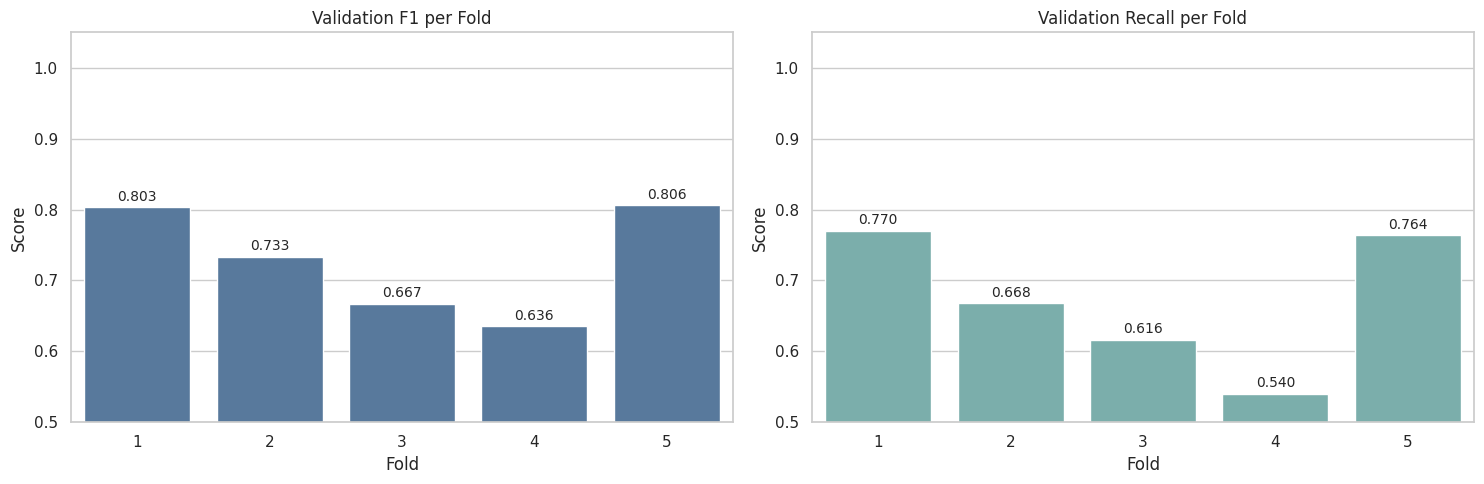

In [6]:
# Cell: Visualize Fold Metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_plot = kfold_df.dropna(subset=["f1", "recall"])  # 只保留有效折

palette = ["#4C78A8"] * len(kfold_df)
sns.barplot(data=kfold_df, x="fold", y="f1", ax=axes[0], color="#4C78A8")
for bar, value in zip(axes[0].patches, kfold_df["f1" ]):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{value:.3f}", ha="center", va="bottom", fontsize=10)
sns.barplot(data=kfold_df, x="fold", y="recall", ax=axes[1], color="#72B7B2")
for bar, value in zip(axes[1].patches, kfold_df["recall" ]):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{value:.3f}", ha="center", va="bottom", fontsize=10)
axes[0].set_title("Validation F1 per Fold")
axes[1].set_title("Validation Recall per Fold")
for ax in axes:
    ax.set_ylim(0.5, 1.05)
    ax.set_xlabel("Fold")
    ax.set_ylabel("Score")

plt.tight_layout()


## 🎯 选择最佳 Fold

In [7]:
# Cell: Select Best Fold
metric_key = BEST_METRIC
best_record = max(kfold_records, key=lambda rec: rec["metrics"].get(metric_key, float("-inf")))
best_fold = best_record["fold"]
best_metrics = best_record["metrics"]
print(f"Best fold: {best_fold} based on metric '{metric_key}' -> {best_metrics}")

best_history_df = pd.DataFrame(best_record["history"])


Best fold: 5 based on metric 'f1' -> {'loss': 0.24689286169078614, 'accuracy': 0.8266666531562805, 'precision': 0.8528151512145996, 'recall': 0.7639999985694885, 'f1': 0.8059641718864441}


## 📈 最佳 Fold 训练曲线

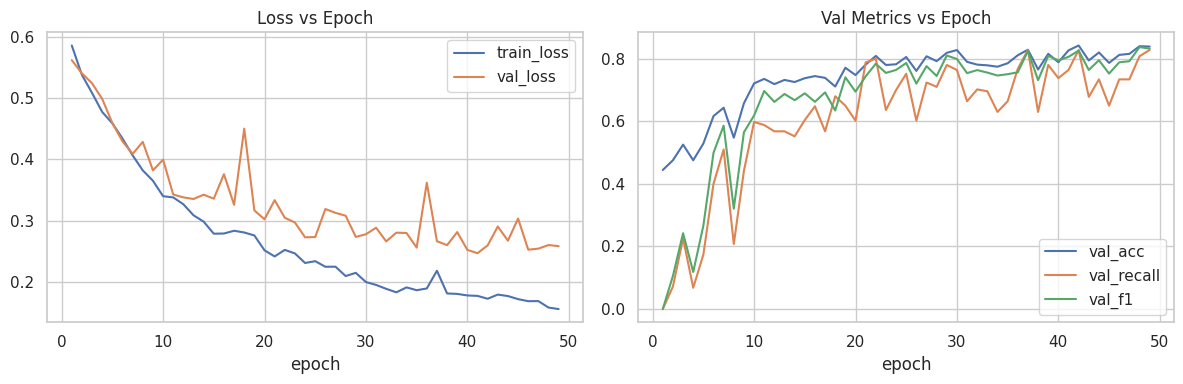

In [8]:
# Cell: Plot Training Curves
if best_history_df.empty:
    print("No history captured for best fold.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    best_history_df.plot(x="epoch", y=["train_loss", "val_loss"], ax=axes[0])
    axes[0].set_title("Loss vs Epoch")
    best_history_df.plot(x="epoch", y=["val_acc", "val_recall", "val_f1"], ax=axes[1])
    axes[1].set_title("Val Metrics vs Epoch")
    plt.tight_layout()


## 🔍 混淆矩阵 (最佳 Fold)

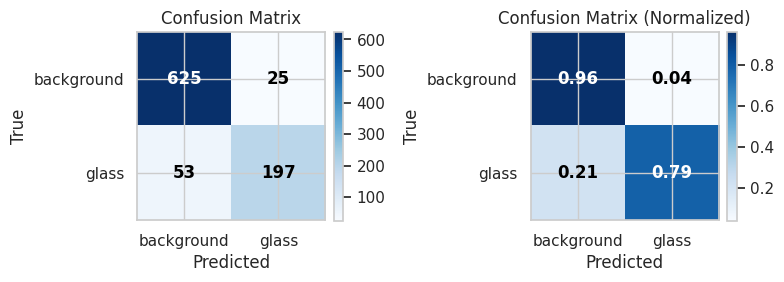

In [9]:
# Cell: Confusion Matrix
best_state = best_record["best_state"]
best_preds = best_state.get("predictions")
best_targets = best_state.get("targets")
if best_preds is None or best_targets is None:
    print("Predictions not cached; cannot plot confusion matrix.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    cm_raw = confusion_matrix(best_preds, best_targets, num_classes=2, normalize=False)
    cm_norm = confusion_matrix(best_preds, best_targets, num_classes=2, normalize=True)
    plot_confusion_matrix(cm_raw, class_names=['background', 'glass'], normalize=False, ax=axes[0])
    plot_confusion_matrix(cm_norm, class_names=['background', 'glass'], normalize=True, ax=axes[1])
    plt.tight_layout()


## 💾 保存最佳 Fold 产物

In [10]:
# Cell: Persist Best Fold Checkpoint & History
best_ckpt_src = best_record.get('checkpoint_path')
if best_ckpt_src is None:
    raise RuntimeError('Best fold checkpoint path missing; ensure output_dir is set in run_kfold_training().')
best_ckpt_src = Path(best_ckpt_src)
best_ckpt_dst = OUTPUT_DIR / 'tinyglassnet_best.pt'
shutil.copy(best_ckpt_src, best_ckpt_dst)
print(f'Checkpoint copied to {best_ckpt_dst}')

history_path = OUTPUT_DIR / 'tinyglassnet_best_history.csv'
best_history_df.to_csv(history_path, index=False)
print(f'History saved to {history_path}')


Checkpoint copied to cache/experiments/tinyglassnet_best.pt
History saved to cache/experiments/tinyglassnet_best_history.csv


## 📦 导出 ONNX (最佳 Fold)

In [11]:
# Cell: Export ONNX
best_model = build_model().to(DEVICE)
best_model.load_state_dict(best_state["model"])
best_model.eval()
example_mel = np.load(index_df.iloc[0]["path"])
example_input = torch.from_numpy(example_mel).unsqueeze(0).unsqueeze(0).float()
onnx_path = export_to_onnx(best_model.to("cpu"), example_input, ONNX_PATH)
print(f"Exported ONNX to {onnx_path}")
best_model.to(DEVICE)


Exported ONNX to cache/experiments/tinyglassnet_best.onnx


TinyGlassNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)